In [ ]:
#| hide
from nbdev.showdoc import *


# Apply to effect size

> Reading a pandas dataframe into the holopheno object

- order: 3

In [ ]:
import holopheno
import pandas as pd
import numpy as np
import dabest
import matplotlib.pyplot as plt
import seaborn as sns

print("We're using DABEST v{}".format(dabest.__version__))
%matplotlib inline


We're using DABEST v2023.03.29


In [ ]:
axis_text_size = 14
raw_marker_size = 5
es_marker_size = 7

In [ ]:
from scipy.stats import norm # Used in generation of populations.
np.random.seed(9999) # Fix the seed so the results are replicable.

# Create samples
N = 20
t_size = norm.rvs(loc=3, scale=0.4, size=N*4)
t_size[N:2*N] = t_size[N:2*N]+1
t_size[2*N:3*N] = t_size[2*N:3*N]-0.5

survival = norm.rvs(loc=15, scale=3, size=N*4)
survival[N:2*N] = survival[N:2*N]-8
survival[2*N:3*N] = survival[2*N:3*N]-0.5


side_effects = norm.rvs(loc=0.4, scale=0.02, size=N*4)
# side_effects[N:2*N] = side_effects[N:2*N]
side_effects[2*N::] = side_effects[2*N::]+0.04




# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Tumor Size'         : t_size,
                   'Survival'         : survival,
                   'Side Effects'         : side_effects
                })




# drug 2
np.random.seed(20) # Fix the seed so the results are replicable.

# Create samples
N = 35
t_size_drug2 = norm.rvs(loc=3, scale=0.3, size=N*4)
t_size_drug2[N:2*N] = t_size_drug2[N:2*N]+0.75
t_size_drug2[2*N:3*N] = t_size_drug2[2*N:3*N]-0.3

survival_drug2 = norm.rvs(loc=15, scale=10, size=N*4)
survival_drug2[N:2*N] = survival_drug2[N:2*N]-8
survival_drug2[3*N:4*N] = survival_drug2[3*N:4*N]-6.5

side_effects_drug2 = norm.rvs(loc=0.4, scale=0.3, size=N*4)
# side_effects[N:2*N] = side_effects[N:2*N]
side_effects_drug2[2*N::] = side_effects_drug2[2*N::]+0.06




# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2_drug2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Tumor Size'         : t_size_drug2,
                   'Survival'         : survival_drug2,
                   'Side Effects'         : side_effects_drug2
                })



In [ ]:
df_delta2['Drug'] = 1
df_delta2_drug2['Drug'] = 2
df = pd.concat([df_delta2, df_delta2_drug2], axis =0)


In [ ]:
analysis_matrix = pd.DataFrame(columns = ['Drug', 'Tumor Size', 'Survival', 'Side Effects'], index = [0, 1])
analysis_matrix
deltags = analysis_matrix.copy()
bca_highs = analysis_matrix.copy()
bca_lows = analysis_matrix.copy()
contrasts = []
for i in deltags.index:
    df0 = df.loc[df['Drug'] == i+1]
    deltags['Drug'][i] = i +1
    bca_highs['Drug'][i] = i +1
    bca_lows['Drug'][i] = i +1
    for col in deltags.columns[1::]:
        contrast = dabest.load(data = df0, x = ["Genotype", "Genotype"], y = col, delta2 = True, experiment = "Treatment")
        contrasts.append(contrast)
        deltags[col][i] = contrast.delta_g.delta_delta.difference
        bca_highs[col][i] = contrast.delta_g.delta_delta.bca_high        
        bca_lows[col][i] = contrast.delta_g.delta_delta.bca_low

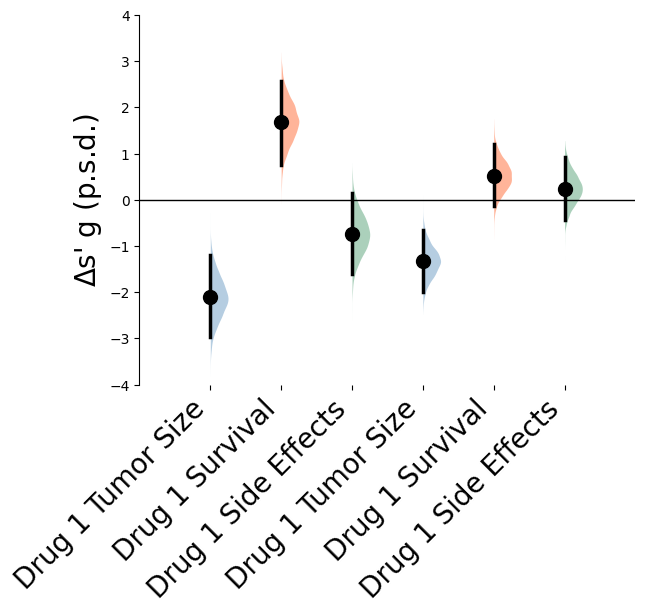

In [ ]:

def forest_plot(contrasts, items, ax = None, colors = None):
    def halfviolin(v, half='right', fill_color='k', alpha=1,
                line_color='k', line_width=0):
        import numpy as np
    
        for b in v['bodies']:
            V = b.get_paths()[0].vertices
    
            mean_vertical = np.mean(V[:, 0])
            mean_horizontal = np.mean(V[:, 1])
    
            if half == 'right':
                V[:, 0] = np.clip(V[:, 0], mean_vertical, np.inf)
            elif half == 'left':
                V[:, 0] = np.clip(V[:, 0], -np.inf, mean_vertical)
            elif half == 'bottom':
                V[:, 1] = np.clip(V[:, 1], -np.inf, mean_horizontal)
            elif half == 'top':
                V[:, 1] = np.clip(V[:, 1], mean_horizontal, np.inf)
    
            b.set_color(fill_color)
            b.set_alpha(alpha)
            b.set_edgecolor(line_color)
            b.set_linewidth(line_width)
    DDbootstraps = [c.delta_g.delta_delta.bootstraps_delta_delta for c in contrasts]

    import matplotlib.pyplot as plt
    default_violinplot_kwargs = {'widths':0.5, 'vert':True,
                                   'showextrema':False, 'showmedians':False}
    v = ax.violinplot(DDbootstraps, **default_violinplot_kwargs)
    halfviolin(v, alpha = 0.4)


    ax.plot([0, len(contrasts)+1], [0, 0], 'k', linewidth = 1)
    ticks = list(range(1, len(contrasts)+1))
    for i in ticks:
        ax.plot(i, contrasts[i-1].delta_g.delta_delta.difference, 'k.', markersize = 20)
        ax.plot([i, i], [contrasts[i-1].delta_g.delta_delta.bca_high, contrasts[i-1].delta_g.delta_delta.bca_low], 'k', linewidth = 2.5)
    ax.set_xticks(ticks)
    ax.set_xlim([0, len(contrasts)+1])
    ax.set_xticklabels(items,
                      rotation = 45, ha = 'right', fontsize = 20)
    ax.set_ylabel('$\Delta$s\' g (p.s.d.)', fontsize = 20)
    # ax.set_ylim(-0.5, 0.2)
    ax.spines['bottom'].set_color(None)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    # ax.spines['left'].set_color(None)
    if colors:
        for i in range(len(colors)):
            ax.collections[i].set_fc(colors[i])
    
    
f_forest_drug_profiles, axes  = plt.subplots(1, 1);
items = ['Drug 1 Tumor Size', 'Drug 1 Survival', 'Drug 1 Side Effects', 'Drug 1 Tumor Size', 'Drug 1 Survival', 'Drug 1 Side Effects']
colors = ['steelblue', 'orangered', 'seagreen', 'steelblue', 'orangered', 'seagreen']
forest_plot(contrasts, items, ax = axes,colors = colors );
axes.set_ylim(-4, 4);


# f_forest_drug_profiles.savefig('forest_drug_profiles.png', dpi = 300)
# f_forest_drug_profiles.savefig('forest_drug_profiles.svg')



In [ ]:
deltags

,Drug,Tumor Size,Survival,Side Effects
0,1,-2.106681,1.684629,-0.73398
1,2,-1.331807,0.522072,0.242906


In [ ]:
deltags
plt.figure()
from holopheno.plot_tools import plot_heatmap
plot_heatmap(deltags, group_by = 'Drug',plot_clustermap=True, fig_size=(2, 1));
# from holopheno import plot_heatmap
# plot_heatmap(data = deltags, group_by = None )



TypeError: plot_heatmap() got an unexpected keyword argument 'plot_clustermap'

<Figure size 640x480 with 0 Axes>

[0, 0]
0.9108608628153056
[0, 1]
0.8847603018317693
[0, 2]
0.8822543061296033
[1, 0]
0.6748854341387547
[1, 1]
0.6841834635821201
[1, 2]
0.6890129869622614


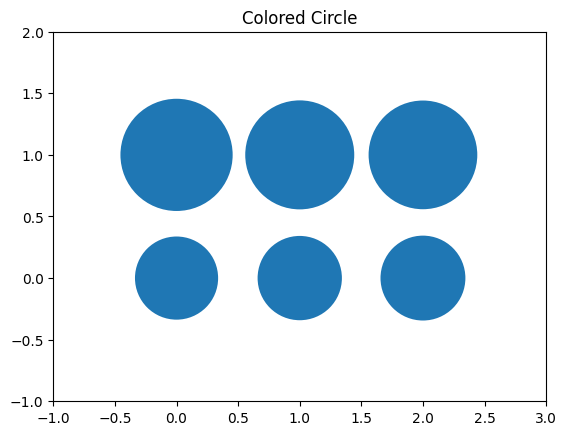

In [ ]:
# figure, axes = plt.subplots()
# group_by = 'Drug'
# pltdf = deltags[deltags.columns[1::]]
# cidf = bca_highs[deltags.columns[1::]] -  deltags[deltags.columns[1::]]
# for i in pltdf.index:
#     for c in range(len(pltdf.columns)):
#         print([i, c])
#         print(cidf.iloc[i, c])
#         effectsizes = plt.Circle(( c, 1-i), cidf.iloc[i, c]/2)
#         axes.set_aspect( 1 )
#         axes.add_artist( effectsizes )
#         axes.set_ylim(-1, 2)
#         axes.set_xlim(-1, 3)
# plt.title( 'Colored Circle' )
# plt.show()




In [ ]:
# deltags_melted = deltags.melt(id_vars=['Drug'], value_vars=deltags.columns[1::])
# map_metrics={'Tumor Size': .1, 'Survival': .2, 'Side Effects': .3}
# deltags_melted['Metric No'] = [map_metrics[i] for i in deltags_melted['variable']]

# bca_highs_melted = bca_highs.melt(id_vars=['Drug'], value_vars=deltags.columns[1::])
# deltags_melted['Size'] = (bca_highs_melted['value'] - deltags_melted['value'])

<AxesSubplot: xlabel='Metric No', ylabel='Drug'>

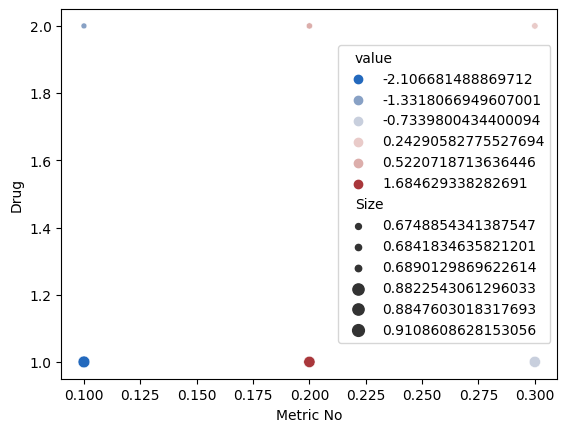

In [ ]:

# sns.scatterplot(data=deltags_melted, x="Metric No", y="Drug", hue="value", palette = 'vlag', size = 'Size')